In [1]:
import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf  # TensorFlow operations

tf.random.set_seed(0)  # set random seed for reproducibility

train_steps = 1200
eval_every = 200
batch_size = 32

train_ds: tf.data.Dataset = tfds.load('mnist', split='train')
test_ds: tf.data.Dataset = tfds.load('mnist', split='test')

train_ds = train_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # normalize train set
test_ds = test_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # normalize test set

# create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
train_ds = train_ds.repeat().shuffle(1024)
# group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
train_ds = train_ds.batch(batch_size, drop_remainder=True).take(train_steps).prefetch(1)
# group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

In [2]:
import jax
jax.config.update("jax_platform_name", "cpu")

In [3]:
from flax import nnx  # Flax NNX API
from functools import partial

class CNN(nnx.Module):
  """A simple CNN model."""

  def __init__(self, *, rngs: nnx.Rngs):
    self.conv1 = nnx.Conv(1, 32, kernel_size=(3, 3), rngs=rngs)
    self.conv2 = nnx.Conv(32, 64, kernel_size=(3, 3), rngs=rngs)
    self.avg_pool = partial(nnx.avg_pool, window_shape=(2, 2), strides=(2, 2))
    self.linear1 = nnx.Linear(3136, 256, rngs=rngs)
    self.linear2 = nnx.Linear(256, 10, rngs=rngs)

  def __call__(self, x):
    x = self.avg_pool(nnx.relu(self.conv1(x)))
    x = self.avg_pool(nnx.relu(self.conv2(x)))
    x = x.reshape(x.shape[0], -1)  # flatten
    x = nnx.relu(self.linear1(x))
    x = self.linear2(x)
    return x

model = CNN(rngs=nnx.Rngs(0))
nnx.display(model)

CNN(
  conv1=Conv(
    kernel_shape=(3, 3, 1, 32),
    kernel=Param(
      value=Array(shape=(3, 3, 1, 32), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    in_features=1,
    out_features=32,
    kernel_size=(3, 3),
    strides=1,
    padding='SAME',
    input_dilation=1,
    kernel_dilation=1,
    feature_group_count=1,
    use_bias=True,
    mask=None,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x0000027A09F0B7E0>,
    bias_init=<function zeros at 0x0000027A059E02C0>,
    conv_general_dilated=<function conv_general_dilated at 0x0000027A055A00E0>
  ),
  conv2=Conv(
    kernel_shape=(3, 3, 32, 64),
    kernel=Param(
      value=Array(shape=(3, 3, 32, 64), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(64,), dtype=float32)
    ),
    in_features=32,
    out_features=64,
    kernel_size=(3, 3),
    strides=1,
    padding='SAME',


In [6]:
import jax.numpy as jnp  # JAX NumPy

y = model(jnp.ones((1, 28, 28, 1)))
nnx.display(y)

[[-0.06820834 -0.14743432  0.00265852 -0.21736552  0.16673796 -0.00923909
  -0.06636676  0.28341877  0.3375435  -0.20142873]]


In [4]:
import optax

learning_rate = 0.005
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

nnx.display(optimizer)

Optimizer(
  step=OptState(
    value=Array(0, dtype=uint32)
  ),
  model=CNN(
    conv1=Conv(
      kernel_shape=(3, 3, 1, 32),
      kernel=Param(
        value=Array(shape=(3, 3, 1, 32), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(32,), dtype=float32)
      ),
      in_features=1,
      out_features=32,
      kernel_size=(3, 3),
      strides=1,
      padding='SAME',
      input_dilation=1,
      kernel_dilation=1,
      feature_group_count=1,
      use_bias=True,
      mask=None,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x0000027A09F0B7E0>,
      bias_init=<function zeros at 0x0000027A059E02C0>,
      conv_general_dilated=<function conv_general_dilated at 0x0000027A055A00E0>
    ),
    conv2=Conv(
      kernel_shape=(3, 3, 32, 64),
      kernel=Param(
        value=Array(shape=(3, 3, 32, 64), dtype=float32)
      ),
      bias=Param(
        value=Arr

In [5]:
def loss_fn(model: CNN, batch):
  logits = model(batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=batch['label']
  ).mean()
  return loss, logits

@nnx.jit
def train_step(model: CNN, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.
  optimizer.update(grads)  # In-place updates.

@nnx.jit
def eval_step(model: CNN, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.

In [7]:
metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

for step, batch in enumerate(train_ds.as_numpy_iterator()):
  # Run the optimization for one step and make a stateful update to the following:
  # - The train state's model parameters
  # - The optimizer state
  # - The training loss and accuracy batch metrics
  train_step(model, optimizer, metrics, batch)

  if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  # One training epoch has passed.
    # Log the training metrics.
    for metric, value in metrics.compute().items():  # Compute the metrics.
      metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
    metrics.reset()  # Reset the metrics for the test set.

    # Compute the metrics on the test set after each training epoch.
    for test_batch in test_ds.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    # Log the test metrics.
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()  # Reset the metrics for the next training epoch.

    print(
      f"[train] step: {step}, "
      f"loss: {metrics_history['train_loss'][-1]}, "
      f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
    )
    print(
      f"[test] step: {step}, "
      f"loss: {metrics_history['test_loss'][-1]}, "
      f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
    )

[train] step: 200, loss: 0.310018390417099, accuracy: 90.1119384765625
[test] step: 200, loss: 0.13747736811637878, accuracy: 95.61297607421875
[train] step: 400, loss: 0.1253398358821869, accuracy: 96.453125
[test] step: 400, loss: 0.07134204357862473, accuracy: 97.76642608642578
[train] step: 600, loss: 0.0899970531463623, accuracy: 97.28125
[test] step: 600, loss: 0.08236681669950485, accuracy: 97.22555541992188
[train] step: 800, loss: 0.0769299566745758, accuracy: 97.546875
[test] step: 800, loss: 0.05987616255879402, accuracy: 97.90664672851562
[train] step: 1000, loss: 0.06693393737077713, accuracy: 97.84375
[test] step: 1000, loss: 0.08666698634624481, accuracy: 97.38581848144531
[train] step: 1199, loss: 0.07529671490192413, accuracy: 97.88002014160156
[test] step: 1199, loss: 0.05713463947176933, accuracy: 98.18710327148438


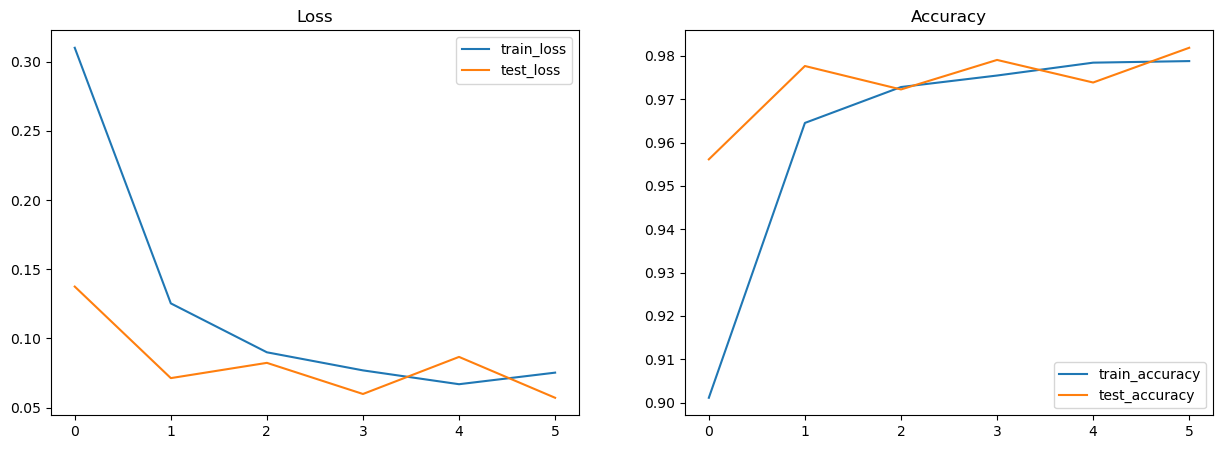

In [8]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

In [9]:
@nnx.jit
def pred_step(model: CNN, batch):
  logits = model(batch['image'])
  return logits.argmax(axis=1)

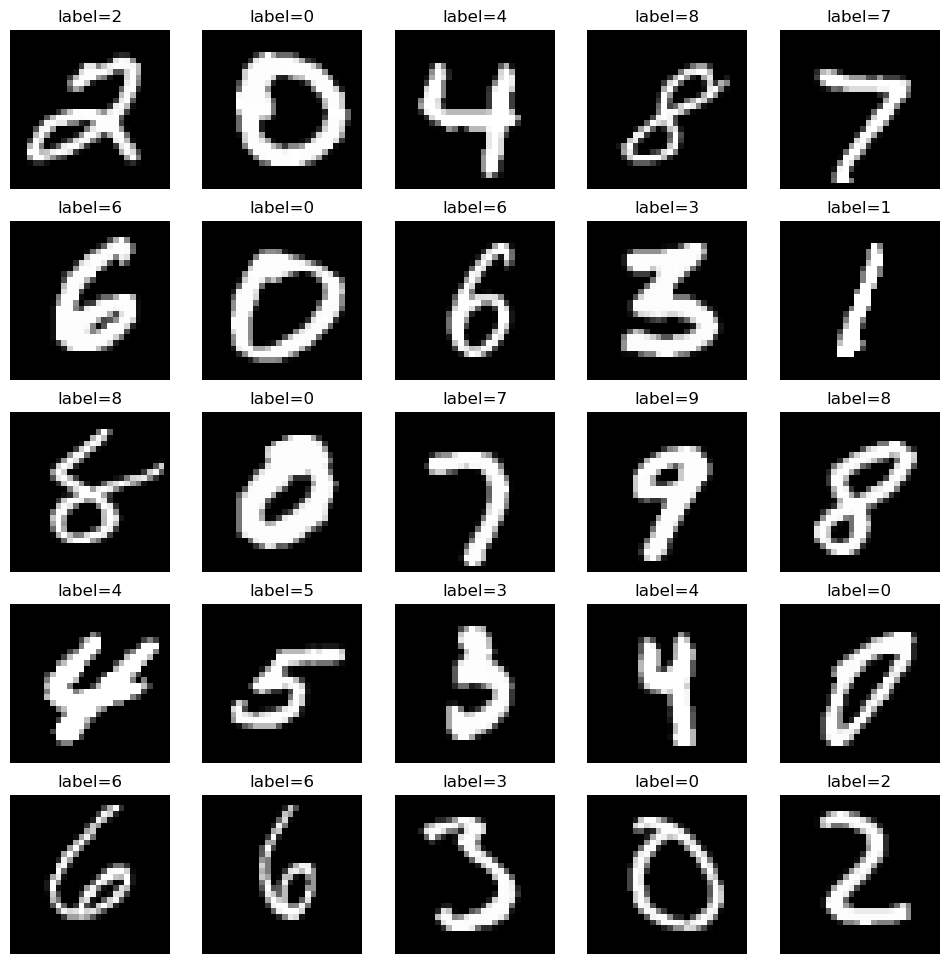

In [10]:
test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(model, test_batch)

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
  ax.set_title(f'label={pred[i]}')
  ax.axis('off')